# Forecasting the geomagnetic indices for the May 2024 superstorm from STEREO-A beacon data

This script calculates the Dst & SYM-H values from STEREO-A and L1 data for the geomagnetic superstorm of 10-12 May 2024. We quantify how well this superstorm can be predicted from a spacecraft positioned closer to the Sun than L1. 

To run this script use the helio4.yml environment.

Operations:
1. Data Reading: STEREO-A beacon, ACE real-time, and OMNI data.
2. Data Processing: Appling time shift and CME expansion to STEREO-A data (i.e. STEREO-A beacon data is mapped to L1).
3. Calculate geomagnetic indices from mapped STEREO-A & L1 data
4. Estimation of the prediction performance.
5. Calculate Shock normals, Mach numbers.

In [1]:
# Conda dependencies are listed under helio4.yml
import os
import sys
import copy
from datetime import datetime, timedelta
import getpass
import logging
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import num2date, date2num
import numpy as np
import pdb
import pickle
import requests
import scipy.io
from scipy import stats
import scipy
import warnings
from sunpy.time import parse_time

import pandas as pd
import matplotlib.dates as mdates
import astropy.units as u

import time
import numba
from numba import jit
from astropy.time import Time, TimeDelta
from functions.data import SatData
from functions.data import PositionData
import urllib

import seaborn as sns
from sklearn.metrics import mean_squared_error

from functions import data as pred

warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

data_path = 'data/'

sns.set_style('whitegrid')
sns.set_context('paper')

c0 = "xkcd:black"
c1 = "xkcd:magenta"
c2 = "xkcd:orange"
c3 = "xkcd:azure"

## 1. DATA READING

1. Reading in STEREO-A data.
2. Read ACE data set.
3. Read OMNI (low and high resolution) data set.

In [2]:
### STEREO-A beacon data ###
[sta_input, sta_header] = pickle.load(open(data_path+'stereoa_beacon_gsm_last_35days_now.p', 'rb'))

#only data for duration of event is required  
sta_cut_lower = np.where(sta_input.time >= parse_time('2024-05-10').datetime)[0][0]
sta_cut_upper = np.where(sta_input.time >= parse_time('2024-05-13').datetime)[0][0]

sta_input = sta_input[sta_cut_lower:sta_cut_upper]


### ACE real-time data ###
[l1_input, l1_header] = pickle.load(open(data_path+'noaa_rtsw_last_35files_now.p', 'rb'))

#only data for duration of event is required
l1_cut_lower = np.where(l1_input.time >= parse_time('2024-05-10').datetime)[0][0]
l1_cut_upper = np.where(l1_input.time >= parse_time('2024-05-13').datetime)[0][0]

l1_input = l1_input[l1_cut_lower:l1_cut_upper]


### OMNI low resolution (OLR) and OMNI high resolution (OHR) data ###
[olr, olr_header] = pickle.load(open(data_path+'omni_1963_now.p', 'rb'))
[ohr, ohr_header] = pickle.load(open(data_path+'omni_high_res2024.p', 'rb'))

olr_cut_lower = np.where(olr.time >= parse_time('2024-05-10').datetime)[0][0]
olr_cut_upper = np.where(olr.time >= parse_time('2024-05-13').datetime)[0][0]

ohr_cut_lower = np.where(ohr.time >= parse_time('2024-05-10').datetime)[0][0]
ohr_cut_upper = np.where(ohr.time >= parse_time('2024-05-13').datetime)[0][0]

olr = olr[olr_cut_lower:olr_cut_upper]
ohr = ohr[ohr_cut_lower:ohr_cut_upper]

print(sta_header)
print('   ')
print(l1_header)
print('   ')
print(olr_header)
print('   ')
print(ohr_header)

STEREO-A beacon magnetic field (IMPACT instrument) and beacon plasma data (PLASTIC), obtained from https://stereo-ssc.nascom.nasa.gov/data/beacon/ahead/impact/ and   https://stereo-ssc.nascom.nasa.gov/data/beacon/ahead/plastic/ Timerange: 2024-Apr-18 09:42 to 2024-May-23 09:42, with an average time resolution of 60 seconds. The data are available in a numpy recarray, fields can be accessed by sta.time, sta.bx, sta.vt etc. Missing data has been set to "np.nan". Total number of data points: 50401. Units are btxyz [nT, GSM], vt [km/s], np[cm^-3], tp [K], heliospheric position x/y/z/r/lon/lat [AU, degree, HEEQ]. Made with https://github.com/cmoestl/heliocats By C. Moestl, E. Weiler, E. E. Davies. File creation date: 2024-May-23 09:44 UTC
   
Real time solar wind magnetic field and plasma data from NOAA, obtained daily from https://services.swpc.noaa.gov/products/solar-wind/  Timerange: 2023-Jul-28 09:29 to 2024-May-17 12:32, linearly interpolated to a time resolution of 146 seconds. The da

### 1.1 Create SatData objects for data handling

In [3]:
l1_0 = SatData({'time': date2num(l1_input.time),
           'btot': l1_input.bt, 'bx': l1_input.bx, 
           'by': l1_input.by, 'bz': l1_input.bz,
           'speed': l1_input.vt, 'density': l1_input.np, 
           'temp': l1_input.tp}, source='ACE')                   

Positions = PositionData([l1_input.r, np.deg2rad(l1_input.lon), np.deg2rad(l1_input.lat)], postype='rlonlat')

Positions.h['Units'] = 'AU'
Positions.h['ReferenceFrame'] = 'HEEQ'
Positions.h['Observer'] = 'Sun'
l1_0.pos = Positions

l1_0.interp_nans()

l1_0.h['DataSource'] = "ACE"
l1_0.h['SamplingRate'] = mdates.num2date(l1_0['time'][1]) - mdates.num2date(l1_0['time'][0])
l1_0.h['referenceFrame'] = 'GSM'
l1_0.h['Instruments'] = ['MAG', 'SWEPAM']
l1_0.h['CoordinateSystem'] = 'rlonlat'

l1_0_hour = l1_0.make_hourly_data()

speed_before_event = np.mean(l1_0['speed'][(l1_0['time']>=mdates.date2num(datetime(2024,5,10,4,3))) & (l1_0['time']<=mdates.date2num(datetime(2024,5,10,14,3)))])
den_before_event = np.mean(l1_0['density'][(l1_0['time']>=mdates.date2num(datetime(2024,5,10,4,3))) & (l1_0['time']<=mdates.date2num(datetime(2024,5,10,14,3)))])
den_during_event_avg = np.mean(l1_0['density'][(l1_0['time']>=mdates.date2num(datetime(2024,5,10,16,37))) & (l1_0['time']<=mdates.date2num(datetime(2024,5,11,14,31)))])
#print(np.std(l1_0['speed'][(l1_0['time']>=mdates.date2num(datetime(2024,5,10,4,3))) & (l1_0['time']<=mdates.date2num(datetime(2024,5,10,14,3)))]))
#print(np.std(l1_0['density'][(l1_0['time']>=mdates.date2num(datetime(2024,5,10,4,3))) & (l1_0['time']<=mdates.date2num(datetime(2024,5,10,14,3)))])) 

print(l1_0)
print('   ')
print(l1_0_hour)
print('   ')
print('Max Btot valu at L1: ', np.max(l1_0['btot']))
print('Time at max Btot value: ', mdates.num2date(l1_0['time'][l1_0['btot']==np.max(l1_0['btot'])])[0])

Length of data:		4320
Keys in data:		['speed', 'density', 'temp', 'bx', 'by', 'bz', 'btot']
First data point:	2024-05-10 00:00:00+00:00
Last data point:	2024-05-12 23:59:00+00:00

Header information:
                   DataSource:	ACE
                    SourceURL:	
                 SamplingRate:	0:01:00
               ReferenceFrame:	
                  FileVersion:	{}
                  Instruments:	['MAG', 'SWEPAM']
                 RemovedTimes:	[]
          PlasmaDataIntegrity:	10
               referenceFrame:	GSM
             CoordinateSystem:	rlonlat

Variable statistics:
         VAR        MEAN         STD
       speed      719.16      179.34
     density        7.74        9.46
        temp   262253.62   254405.28
          bx       -4.85        6.62
          by        1.06       15.79
          bz       -5.88       13.17
        btot       16.11       16.32

   
Length of data:		71
Keys in data:		['speed', 'density', 'temp', 'bx', 'by', 'bz', 'btot']
First data point:	2024-0

In [4]:
# Make a SatData Object out of STEREO-A input data

sta_0 = SatData({'time': date2num(sta_input.time),
               'btot': sta_input.bt, 'bx': sta_input.bx, 
               'by': sta_input.by, 'bz': sta_input.bz,
                #'speed': sc_input.vt, 'density': sc_input.np,
                'speed': np.ones(len(sta_input.time)), 'density': np.ones(len(sta_input.time))*11.5, #density from ICMECAT 
                'temp': sta_input.tp}, source='STEREO-A')

Positions = PositionData([sta_input.r, np.deg2rad(sta_input.lon), np.deg2rad(sta_input.lat)], postype='rlonlat')

Positions.h['Units'] = 'AU'
Positions.h['ReferenceFrame'] = 'HEEQ'
Positions.h['Observer'] = 'Sun'
sta_0.pos = Positions

sta_0.interp_nans()

sta_0.h['DataSource'] = "STEREO-A Beacon"
sta_0.h['SamplingRate'] = mdates.num2date(sta_0['time'][1]) - mdates.num2date(sta_0['time'][0])
sta_0.h['referenceFrame'] = 'GSM'
sta_0.h['Instruments'] = ['IMPACT']
sta_0.h['CoordinateSystem'] = 'rlonlat'

sta_0['speed'][(sta_0['time']<mdates.date2num(datetime(2024,5,10,14,3)))]=speed_before_event #from L1 data
sta_0['speed'][(sta_0['time']>=mdates.date2num(datetime(2024,5,10,14,3)))]=725 #from ELEvo
sta_0['density'][(sta_0['time']<mdates.date2num(datetime(2024,5,10,14,3)))]=den_before_event #from L1 data

sta_0_hour = sta_0.make_hourly_data()

print(sta_0)
print('   ')
print(sta_0_hour)

Length of data:		4320
Keys in data:		['speed', 'density', 'temp', 'bx', 'by', 'bz', 'btot']
First data point:	2024-05-10 00:00:00+00:00
Last data point:	2024-05-12 23:59:00+00:00

Header information:
                   DataSource:	STEREO-A Beacon
                    SourceURL:	
                 SamplingRate:	0:01:00
               ReferenceFrame:	
                  FileVersion:	{}
                  Instruments:	['IMPACT']
                 RemovedTimes:	[]
          PlasmaDataIntegrity:	10
               referenceFrame:	GSM
             CoordinateSystem:	rlonlat

Variable statistics:
         VAR        MEAN         STD
       speed      664.82      122.22
     density       10.45        2.14
        temp        0.00        0.00
          bx       -3.12       10.58
          by       -3.25       18.09
          bz       -0.24       18.84
        btot       22.25       17.87

   
Length of data:		71
Keys in data:		['speed', 'density', 'temp', 'bx', 'by', 'bz', 'btot']
First data point:	2

### 1.2 Plot minute and hourly sampled STEREO-A beacon data

Text(0, 0.5, 'B$_{z}$ [nT]')

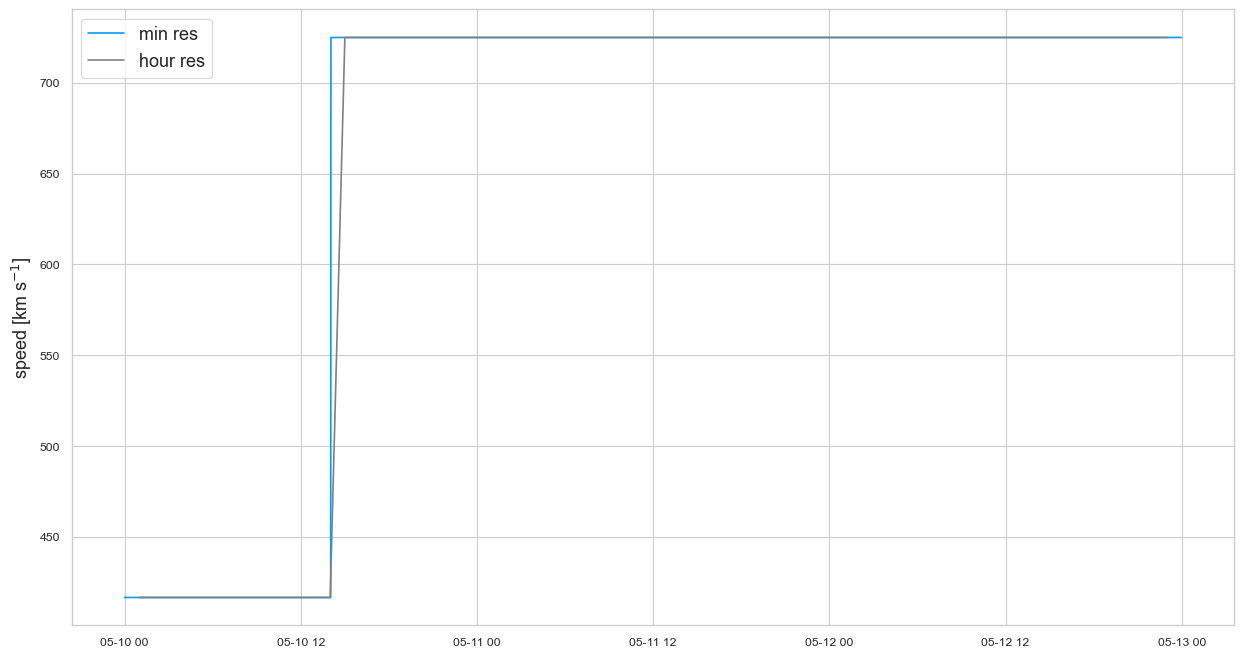

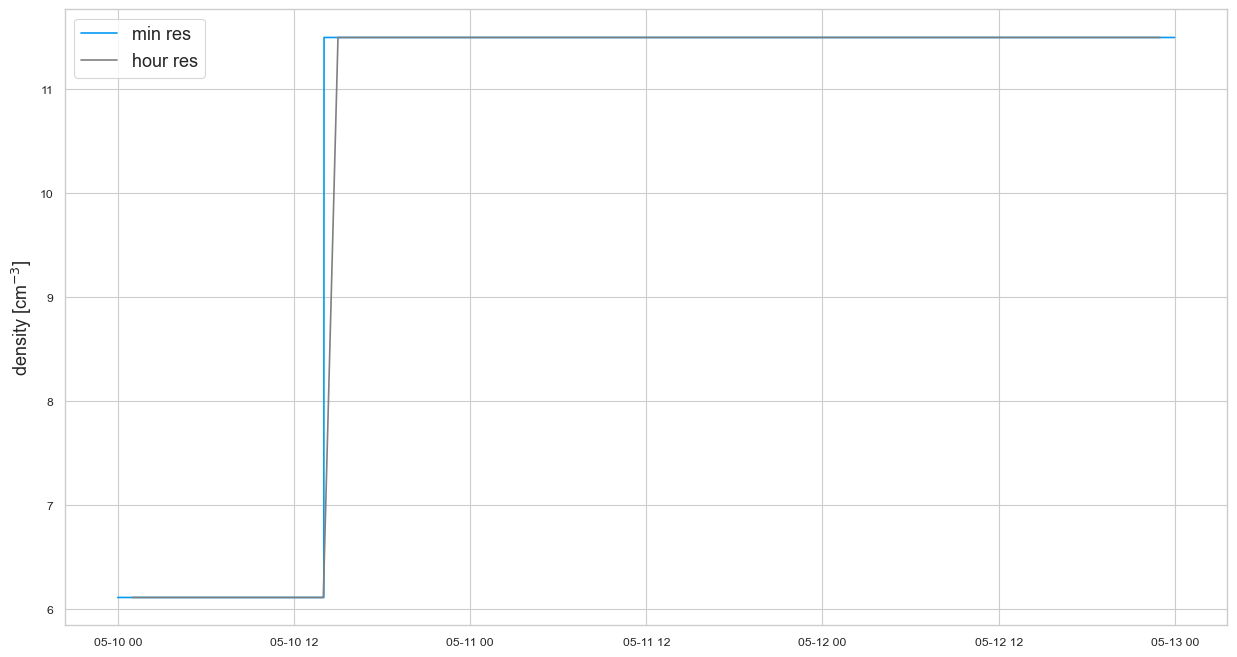

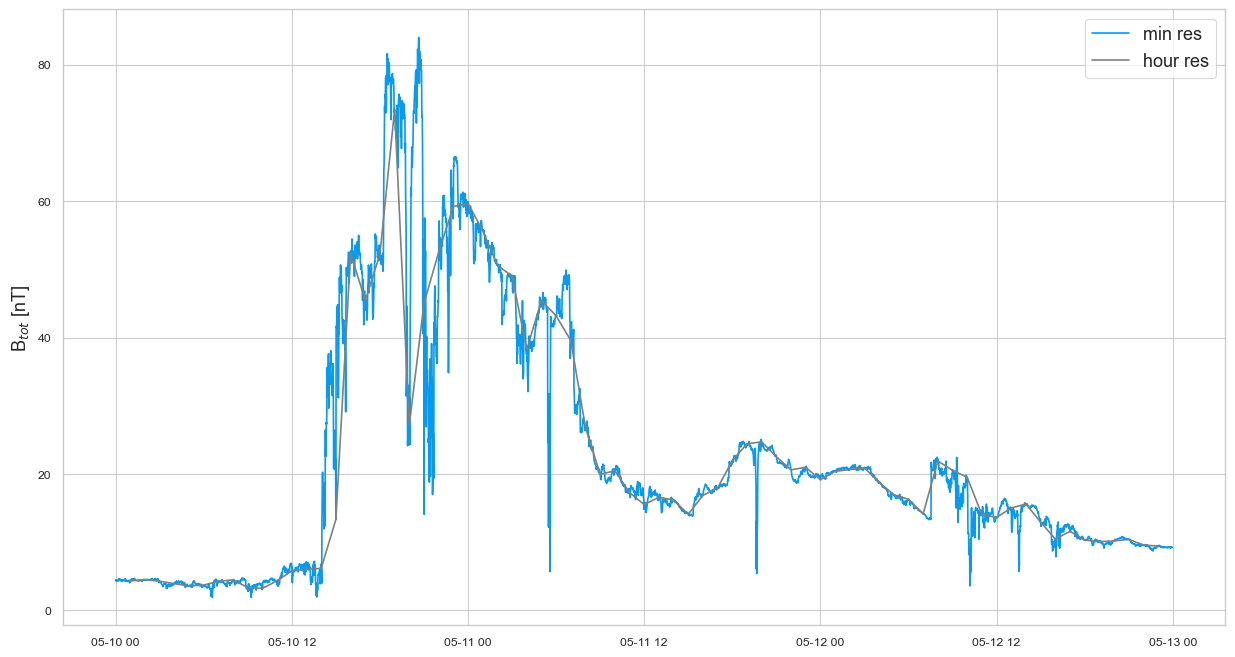

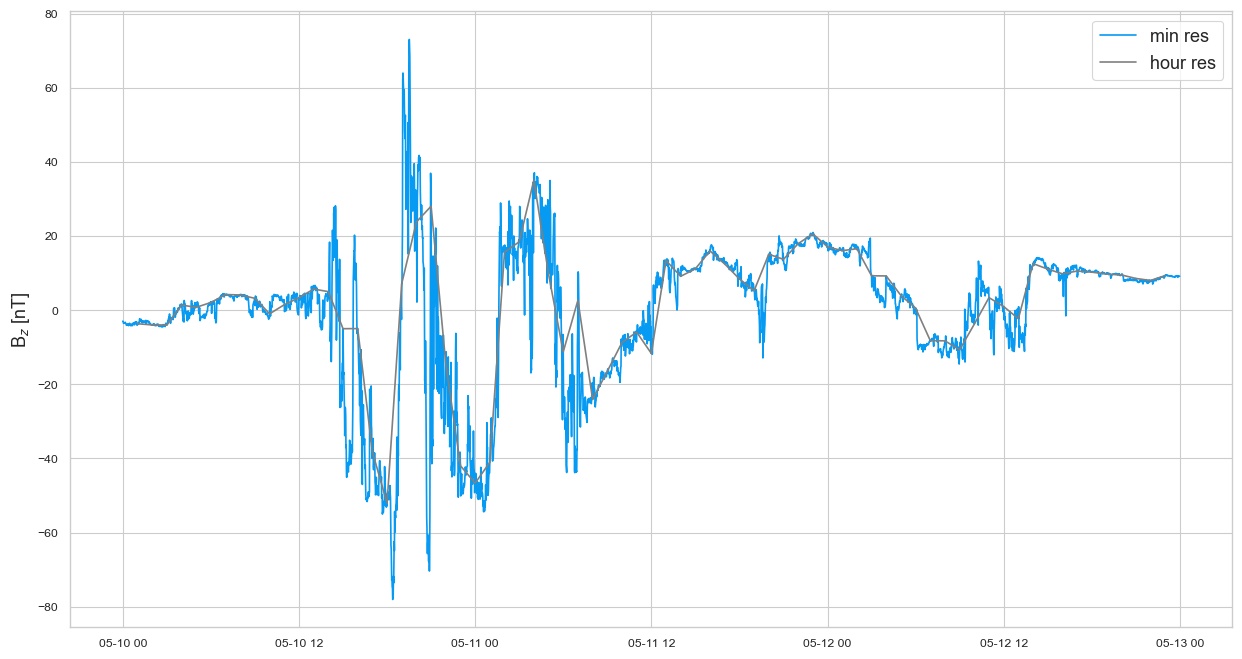

In [5]:
plt.figure(1, figsize=(15,8))
plt.plot(mdates.num2date(sta_0['time']), sta_0['speed'], c=c3, label='min res')
plt.plot(mdates.num2date(sta_0_hour['time']), sta_0_hour['speed'], c='gray', label='hour res')
plt.legend(fontsize=13)
plt.ylabel(r'speed [km s$^{-1}$]', fontsize=13)

plt.figure(2, figsize=(15,8))
plt.plot(mdates.num2date(sta_0['time']), sta_0['density'], c=c3, label='min res')
plt.plot(mdates.num2date(sta_0_hour['time']), sta_0_hour['density'], c='gray', label='hour res')
plt.legend(fontsize=13)
plt.ylabel(r'density [cm$^{-3}$]', fontsize=13)

plt.figure(3, figsize=(15,8))
plt.plot(mdates.num2date(sta_0['time']), sta_0['btot'], c=c3, label='min res')
plt.plot(mdates.num2date(sta_0_hour['time']), sta_0_hour['btot'], c='gray', label='hour res')
plt.legend(fontsize=13)
plt.ylabel(r'B$_{tot}$ [nT]', fontsize=13)

plt.figure(4, figsize=(15,8))
plt.plot(mdates.num2date(sta_0['time']), sta_0['bz'], c=c3, label='min res')
plt.plot(mdates.num2date(sta_0_hour['time']), sta_0_hour['bz'], c='gray', label='hour res')
plt.legend(fontsize=13)
plt.ylabel(r'B$_{z}$ [nT]', fontsize=13)

## 2. Processing of STEREO-A beacon data for TL model

### 2.1 Calculate time shift to L1 from ELEvo arrival speed output and radial distance between STEREO-A and L1

In [6]:
sta_arrival_elevo = np.genfromtxt(data_path+'ELEvo_may2024_STA.txt', delimiter=' ')
sta_arr_speed = sta_arrival_elevo[:,7]
sta_arr_speed_err = sta_arrival_elevo[:,8]
mean_sta_arr_speed = round(np.mean(sta_arr_speed),0)
print('Mean predicted arrival speed at STEREO-A as issued by ELEvo: ', mean_sta_arr_speed, 'km/s')

l1_position = pickle.load(open(data_path+'l1_pos_2024.p', 'rb'))
l1_cut_lower = np.where(l1_position.time >= parse_time('2024-05-10').datetime)[0][0]
l1_cut_upper = np.where(l1_position.time >= parse_time('2024-05-13').datetime)[0][0]

l1_position = l1_position[l1_cut_lower:l1_cut_upper]

Mean predicted arrival speed at STEREO-A as issued by ELEvo:  725.0 km/s


In [7]:
shock_arrival_sta = datetime(2024,5,10,14,3)

index_l1 = np.where(l1_position.time==shock_arrival_sta)[0][0]

shock_arrival_speed = mean_sta_arr_speed #output from ELEvo, average from all five CMEs

r_distance = (l1_position.r[index_l1]-sta_0.pos['r'][index_l1])*u.au.to(u.km)
time_shift_minutes = (l1_position.r[index_l1]-sta_0.pos['r'][index_l1])*u.au.to(u.km)/shock_arrival_speed/60.

print('Time shift for STEREO-A data set (hours): ', round(time_shift_minutes/60.,1), 'hours')
print('Error in minutes to real time shift: ', round((time_shift_minutes/60.-2.57)*60,0), 'min')

time_shift_error = np.sqrt((-r_distance/sta_arr_speed[0]**2*sta_arr_speed_err[0])**2+(-r_distance/sta_arr_speed[1]**2*sta_arr_speed_err[1])**2+(-r_distance/sta_arr_speed[2]**2*sta_arr_speed_err[2])**2++(-r_distance/sta_arr_speed[3]**2*sta_arr_speed_err[3])**2++(-r_distance/sta_arr_speed[4]**2*sta_arr_speed_err[4])**2)
time_shift_error = time_shift_error/60./60./24.

Time shift for STEREO-A data set (hours):  2.5 hours
Error in minutes to real time shift:  -5.0 min


### 2.2 Scale magnetic field values of STEREO-A (scaling factor = -1.66) and plot mapped magnetic field data

scaling factor=  -1.66


Text(0, 0.5, 'Btot')

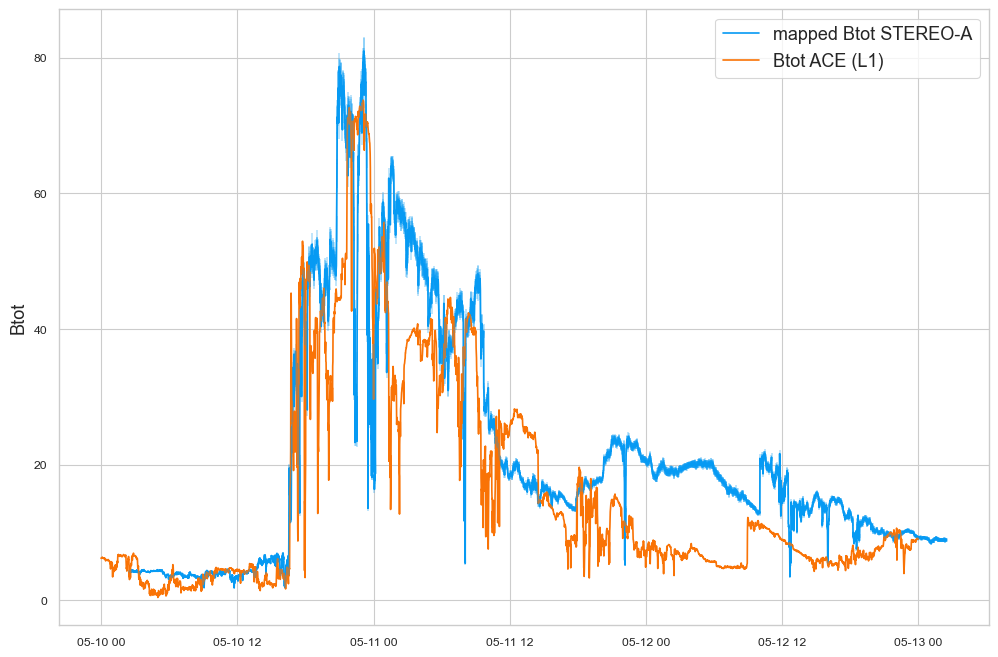

In [8]:
sta_scaled = copy.deepcopy(sta_0)
sta_scaled = sta_scaled.shift_wind_to_L1(l1_position)
sta_scaled_shifted = copy.deepcopy(sta_scaled)

sta_scaled_hour = sta_scaled.make_hourly_data()
sta_scaled_shifted_hour = copy.deepcopy(sta_scaled_hour)

sta_scaled_shifted['time'] = sta_scaled_shifted['time']+time_shift_minutes/60./24.
sta_scaled_shifted_hour['time'] = sta_scaled_shifted_hour['time']+time_shift_minutes/60./24.

plt.figure(1, figsize=(12,8))
plt.plot(mdates.num2date(sta_scaled_shifted['time']), sta_scaled_shifted['btot'], color=c3, label='mapped Btot STEREO-A')
plt.errorbar(mdates.num2date(sta_scaled_shifted['time']), sta_scaled_shifted['btot'], yerr=sta_scaled_shifted['btot_err'],color=c3, alpha=0.3)
plt.plot(l1_0['time'], l1_0['btot'], color=c2, label='Btot ACE (L1)')
plt.legend(fontsize=13)
plt.ylabel('Btot', fontsize=13)

## 3. Calculate geomagnetic indices from mapped STEREO-A & L1 data using an ensemble

In [9]:
n_ensembles = 100000

start_time_calculation = time.time()

sta_event_start = datetime(2024,5,10,14,3)+timedelta(minutes=time_shift_minutes)
sta_event_end = datetime(2024,5,11,13,46)+timedelta(minutes=time_shift_minutes)

dst1_input = np.abs(np.random.normal(10, 2, n_ensembles))
dst2_input = np.abs(np.random.normal(6, 1, n_ensembles))
dst3_input = np.abs(np.random.normal(10, 2, n_ensembles))

### min resolution ###
btot_array = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_scaled_shifted['btot'], sta_scaled_shifted['btot_err'])]) 
btot_array = np.transpose(btot_array)

bx_array = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_scaled_shifted['bx'], sta_scaled_shifted['bx_err'])]) 
bx_array = np.transpose(bx_array)

by_array = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_scaled_shifted['by'], sta_scaled_shifted['by_err'])]) 
by_array = np.transpose(by_array)

bz_array = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_scaled_shifted['bz'], sta_scaled_shifted['bz_err'])])  
bz_array = np.transpose(bz_array)

speed_array = np.array([np.random.normal(k, np.std([k-0.16*k,k,k+0.16*k]), n_ensembles) for k in sta_scaled_shifted['speed']]) #0.16 results from 118/725, where 118 is the error of the averaged arrival speeds 
speed_array = np.transpose(speed_array)

density_array = np.abs(np.array([np.random.normal(k, np.std([k-0.3*k,k,k+0.3*k]), n_ensembles) for k in sta_scaled_shifted['density']]))
density_array = np.transpose(density_array)


### hour resolution ###
btot_array_hour = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_scaled_shifted_hour['btot'], sta_scaled_shifted_hour['btot_err'])]) 
btot_array_hour = np.transpose(btot_array_hour)

bx_array_hour = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_scaled_shifted_hour['bx'], sta_scaled_shifted_hour['bx_err'])]) 
bx_array_hour = np.transpose(bx_array_hour)

by_array_hour = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_scaled_shifted_hour['by'], sta_scaled_shifted_hour['by_err'])]) 
by_array_hour = np.transpose(by_array_hour)

bz_array_hour = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_scaled_shifted_hour['bz'], sta_scaled_shifted_hour['bz_err'])]) 
bz_array_hour = np.transpose(bz_array_hour)

speed_array_hour = np.array([np.random.normal(k, np.std([k-0.16*k,k,k+0.16*k]), n_ensembles) for k in sta_scaled_shifted_hour['speed']])
speed_array_hour = np.transpose(speed_array_hour)

density_array_hour = np.abs(np.array([np.random.normal(k, np.std([k-0.3*k,k,k+0.3*k]), n_ensembles) for k in sta_scaled_shifted_hour['density']]))
density_array_hour = np.transpose(density_array_hour)

random_time_shift = np.random.normal(0, time_shift_error, n_ensembles)

sta_symh = []
sta_symh_err = []
sta_dst = []
sta_dst_err = []
l1_symh = []
l1_dst = []
    
for x in range(n_ensembles):
    
    sta_symh_rand = pred.calc_dst_temerin_li(sta_scaled_shifted['time']+random_time_shift[x], btot_array[x], bx_array[x], by_array[x], bz_array[x], speed_array[x], speed_array[x], density_array[x], dst1=-dst1_input[x], dst2=-dst2_input[x], dst3=-dst3_input[x], version='2006', linear_t_correction=True, minute_res=True)
    sta_dst_rand = pred.calc_dst_temerin_li(sta_scaled_hour['time']+random_time_shift[x], btot_array_hour[x], bx_array_hour[x], by_array_hour[x], bz_array_hour[x], speed_array_hour[x], speed_array_hour[x], density_array_hour[x], dst1=-dst1_input[x], dst2=-dst2_input[x], dst3=-dst3_input[x], version='2006', linear_t_correction=True, minute_res=False)
    l1_symh_rand = pred.calc_dst_temerin_li(l1_0['time'], l1_0['btot'], l1_0['bx'], l1_0['by'], l1_0['bz'], l1_0['speed'], l1_0['speed'], l1_0['density'], dst1=-dst1_input[x], dst2=-dst2_input[x], dst3=-dst3_input[x], version='2006', linear_t_correction=True, minute_res=True) #DSCOVR input (without speedx)
    l1_dst_rand = pred.calc_dst_temerin_li(l1_0_hour['time'], l1_0_hour['btot'], l1_0_hour['bx'], l1_0_hour['by'], l1_0_hour['bz'], l1_0_hour['speed'], l1_0_hour['speed'], l1_0_hour['density'], dst1=-dst1_input[x], dst2=-dst2_input[x], dst3=-dst3_input[x], version='2006', linear_t_correction=True, minute_res=False)
    
    sta_symh.append(sta_symh_rand)
    sta_dst.append(sta_dst_rand)
    l1_symh.append(l1_symh_rand)
    l1_dst.append(l1_dst_rand)

    
sta_scaled_shifted['symh']= np.mean(sta_symh, axis=0)
sta_scaled_shifted['symh_err_min']=np.mean(sta_symh,axis=0)-np.std(sta_symh, axis=0)
sta_scaled_shifted['symh_err_max']=np.mean(sta_symh,axis=0)+np.std(sta_symh, axis=0)
l1_0['symh']= np.mean(l1_symh, axis=0)
l1_0['symh_err']= np.std(l1_symh, axis=0)

sta_scaled_shifted_hour['dst']= np.mean(sta_dst, axis=0)
sta_scaled_shifted_hour['dst_err_min']= np.mean(sta_dst, axis=0)-np.std(sta_dst, axis=0)
sta_scaled_shifted_hour['dst_err_max']= np.mean(sta_dst, axis=0)+np.std(sta_dst, axis=0)
l1_0_hour['dst']= np.mean(l1_dst, axis=0)
l1_0_hour['dst_err']= np.std(l1_dst, axis=0)

end_time_calculation = time.time()

print('Time in seconds needed for calculation: ', round(end_time_calculation-start_time_calculation,1), ' seconds, using ', n_ensembles, 'ensemble members')


Time in seconds needed for calculation:  870.3  seconds, using  100000 ensemble members


### 3.1 Plot ensemble for specific time (set by index1)

Text(0.5, 0, 'Time shift [hours]')

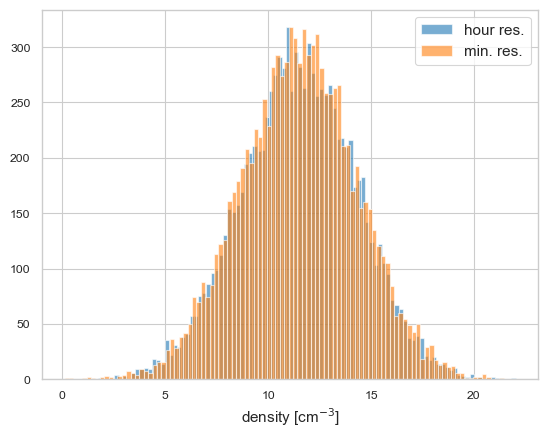

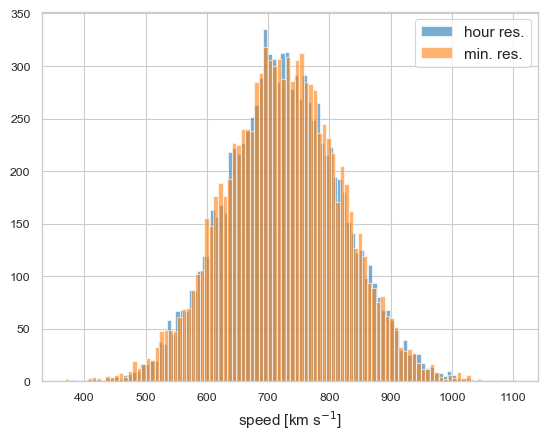

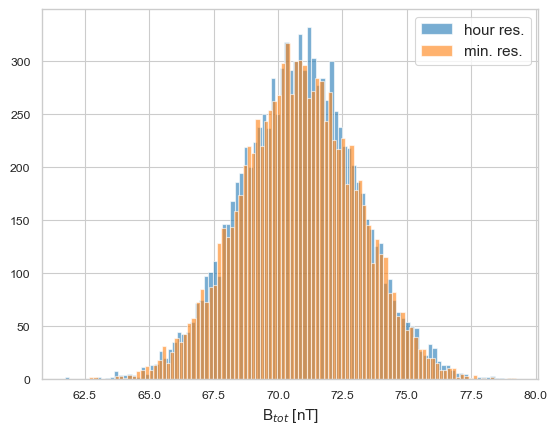

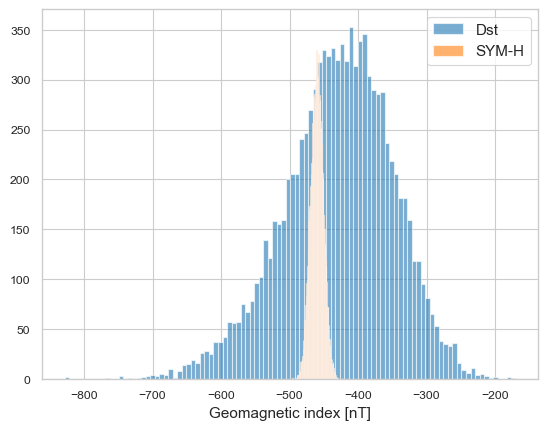

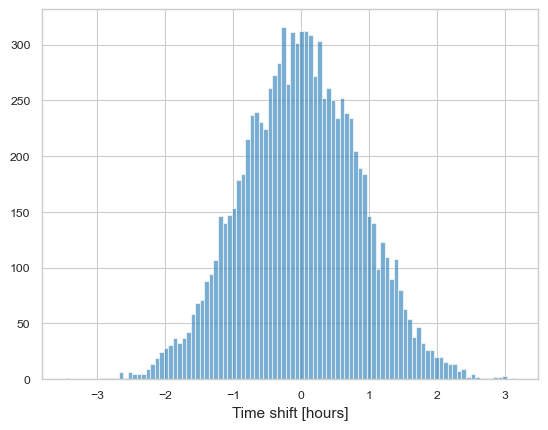

In [17]:
sta_symh_ensemble = np.transpose(sta_symh)
sta_dst_ensemble = np.transpose(sta_dst)

index1 = 19            #index for hour resolution
index2 = index1*60+60  #index for minute resolution

density_ensemble = np.transpose(density_array_hour)
speed_ensemble = np.transpose(speed_array_hour)
btot_ensemble = np.transpose(btot_array_hour)
bx_ensemble = np.transpose(bx_array_hour)
by_ensemble = np.transpose(by_array_hour)
bz_ensemble = np.transpose(bz_array_hour)

density_ensemble1 = np.transpose(density_array)
speed_ensemble1 = np.transpose(speed_array)
btot_ensemble1 = np.transpose(btot_array)
sta_ensemble1 = np.transpose(sta_symh)
bx_ensembles1 = np.transpose(bx_array)
by_ensemble1 = np.transpose(by_array)
bz_ensemble1 = np.transpose(bz_array)

plt.figure(1)
plt.hist(density_ensemble[index1], bins=100, alpha=0.6, label='hour res.')
plt.hist(density_ensemble1[index2], bins=100, alpha=0.6, label='min. res.')
plt.xlabel(r'density [cm$^{-3}$]', fontsize=11)
plt.legend(fontsize=11)

plt.figure(2)
plt.hist(speed_ensemble[index1], bins=100, alpha=0.6, label='hour res.')
plt.hist(speed_ensemble1[index2], bins=100, alpha=0.6, label='min. res.')
plt.xlabel(r'speed [km s$^{-1}$]', fontsize=11)
plt.legend(fontsize=11)

plt.figure(3)
plt.hist(btot_ensemble[index1], bins=100, alpha=0.6, label='hour res.')
plt.hist(btot_ensemble1[index2], bins=100, alpha=0.6, label='min. res.')
plt.xlabel(r'B$_{tot}$ [nT]', fontsize=11)
plt.legend(fontsize=11)

plt.figure(4)
plt.hist(sta_dst_ensemble[index1], bins=100, label='Dst', alpha=0.6)
plt.hist(sta_symh_ensemble[index2], bins=100, label='SYM-H', alpha=0.6)
plt.xlabel(r'Geomagnetic index [nT]', fontsize=11)
plt.legend(fontsize=11)

plt.figure(5)
plt.hist(random_time_shift*24, bins=100, alpha=0.6)
plt.xlabel('Time shift [hours]', fontsize=11)
#plt.figure(9)
#plt.hist(dst1_input,bins=100)
#plt.figure(10)
#plt.hist(dst2_input,bins=100)
#plt.figure(11)
#plt.hist(dst3_input,bins=100)

## 4. Calculate error metrics 

In [11]:
### calculate RMSE, MAE and Delta SYM-H (minute resolution) ###

print('ERROR METRICS FOR SYM-H')
print('  ')

new_inds_wind = np.where((l1_0['time'] >= date2num(sta_event_start)) & (l1_0['time'] <= date2num(sta_event_end)))[0]
new_inds_omni = np.where((ohr['time'] >= sta_event_start) & (ohr['time'] <= sta_event_end))[0]

sta_shifted_to_l1_shock = copy.deepcopy(sta_scaled_shifted)
sta_shifted_interp = sta_shifted_to_l1_shock.interp_to_time(l1_0['time'])
new_inds_sta_interp = np.where((sta_shifted_interp['time'] >= date2num(sta_event_start)) & (sta_shifted_interp['time'] <= date2num(sta_event_end)))[0]

sta_shifted_to_omni_shock = copy.deepcopy(sta_scaled_shifted)
sta_shifted_interp_omni = sta_shifted_to_omni_shock.interp_to_time(mdates.date2num(ohr['time']))
new_inds_sta_interp_omni = np.where((sta_shifted_interp_omni['time'] >= date2num(sta_event_start)) & (sta_shifted_interp_omni['time'] <= date2num(sta_event_end)))[0]

rmse = np.round(np.sqrt(np.sum((ohr['symh'][new_inds_omni]-sta_shifted_to_l1_shock['symh'][new_inds_sta_interp_omni])**2)/len(ohr['symh'][new_inds_omni])),2)
mae = np.round(1/len(ohr['symh'][new_inds_omni])*np.sum(np.abs(ohr['symh'][new_inds_omni]-sta_shifted_to_l1_shock['symh'][new_inds_sta_interp_omni])),2)
rmse_l1 = np.round(np.sqrt(np.sum((l1_0['symh'][new_inds_wind]-sta_shifted_interp['symh'][new_inds_sta_interp])**2)/len(l1_0['symh'][new_inds_wind])),2)
rmse_bz_l1 = np.round(np.sqrt(np.sum((l1_0['bz'][new_inds_wind]-sta_shifted_interp['bz'][new_inds_sta_interp])**2)/len(l1_0['bz'][new_inds_wind])),2)
mae_l1 = np.round(1/len(l1_0['symh'][new_inds_wind])*np.sum(np.abs(l1_0['symh'][new_inds_wind]-sta_shifted_interp['symh'][new_inds_sta_interp])),2)
rmse_l1_omni = np.round(np.sqrt(np.sum((ohr['symh'][new_inds_omni]-l1_0['symh'][new_inds_wind])**2)/len(ohr['symh'][new_inds_omni])),2)
mae_l1_omni = np.round(1/len(ohr['symh'][new_inds_omni])*np.sum(np.abs(ohr['symh'][new_inds_omni]-l1_0['symh'][new_inds_wind])),2)
ppmc1 = np.round(np.corrcoef(l1_0['symh'][new_inds_wind], sta_shifted_interp['symh'][new_inds_sta_interp])[0][1],2)
ppmc2 = np.round(stats.pearsonr(l1_0['symh'][new_inds_wind], sta_shifted_interp['symh'][new_inds_sta_interp]),2)

delta_symh_obs = sta_shifted_interp_omni['symh']-ohr['symh']
delta_symh_l1 = sta_shifted_interp['symh']-l1_0['symh']

print('RMSE (SYM-H - STEREO-A, OMNI): ', rmse)
print('MAE (SYM-H - STEREO-A, OMNI): ', mae)
print('RMSE (SYMH - STEREO-A, L1): ', rmse_l1)
print('MAE (SYMH - STEREO-A, L1: ', mae_l1)
print('RMSE (SYMH - OMNI, L1): ', rmse_l1_omni)
print('MAE (SYMH - OMNI, L1): ', mae_l1_omni)
print('RMSE (Bz - STEREO-A, L1 (min. res.)): ', rmse_bz_l1)
print('Pearson correlation (min. res.): ', ppmc1, ppmc2)
print('  ')

### calculate RMSE, MAE and Delta Dst (hour resolution) ###

print('ERROR METRICS FOR DST')
print('  ')


new_inds_l1_hour = np.where((l1_0_hour['time'] >= date2num(sta_event_start)) & (l1_0_hour['time'] <= date2num(sta_event_end)))[0]
new_inds_omni_hour = np.where((olr['time'] >= sta_event_start) & (olr['time'] <= sta_event_end))[0]

sta_shifted_to_l1_shock_hour = copy.deepcopy(sta_scaled_shifted_hour)
sta_shifted_interp_hour = sta_shifted_to_l1_shock_hour.interp_to_time(l1_0_hour['time'])
new_inds_sta_interp_hour = np.where((sta_shifted_interp_hour['time'] >= date2num(sta_event_start)) & (sta_shifted_interp_hour['time'] <= date2num(sta_event_end)))[0]

sta_shifted_to_omni_shock_hour = copy.deepcopy(sta_scaled_shifted_hour)
sta_shifted_interp_omni_hour = sta_shifted_to_omni_shock_hour.interp_to_time(mdates.date2num(olr['time']))
new_inds_sta_interp_omni_hour = np.where((sta_shifted_interp_omni_hour['time'] >= date2num(sta_event_start)) & (sta_shifted_interp_omni_hour['time'] <= date2num(sta_event_end)))[0]

rmse_hour = np.round(np.sqrt(np.sum((olr['dst'][new_inds_omni_hour]-sta_shifted_to_l1_shock_hour['dst'][new_inds_sta_interp_omni_hour])**2)/len(olr['dst'][new_inds_omni_hour])),2)
mae_hour = np.round(1/len(olr['dst'][new_inds_omni_hour])*np.sum(np.abs(olr['dst'][new_inds_omni_hour]-sta_shifted_to_l1_shock_hour['dst'][new_inds_sta_interp_omni_hour])),2)
rmse_l1_hour = np.round(np.sqrt(np.sum((l1_0_hour['dst'][new_inds_l1_hour]-sta_shifted_interp_hour['dst'][new_inds_sta_interp_hour])**2)/len(l1_0_hour['dst'][new_inds_l1_hour])),2)
rmse_bz_l1_hour = np.round(np.sqrt(np.sum((l1_0_hour['bz'][new_inds_l1_hour]-sta_shifted_interp_hour['bz'][new_inds_sta_interp_hour])**2)/len(l1_0_hour['bz'][new_inds_l1_hour])),2)
mae_l1_hour = np.round(1/len(l1_0_hour['dst'][new_inds_l1_hour])*np.sum(np.abs(l1_0_hour['dst'][new_inds_l1_hour]-sta_shifted_interp_hour['dst'][new_inds_sta_interp_hour])),2)
rmse_l1_omni_hour = np.round(np.sqrt(np.sum((olr['dst'][new_inds_omni_hour]-l1_0_hour['dst'][new_inds_l1_hour])**2)/len(olr['dst'][new_inds_omni_hour])),2)
mae_l1_omni_hour = np.round(1/len(olr['dst'][new_inds_omni_hour])*np.sum(np.abs(olr['dst'][new_inds_omni_hour]-l1_0_hour['dst'][new_inds_l1_hour])),2)
ppmc1_hour = np.round(np.corrcoef(l1_0_hour['dst'][new_inds_l1_hour], sta_shifted_interp_hour['dst'][new_inds_sta_interp_hour])[0][1],2)
ppmc2_hour = np.round(stats.pearsonr(l1_0_hour['dst'][new_inds_l1_hour], sta_shifted_interp_hour['dst'][new_inds_sta_interp_hour]),2)

delta_symh_obs_hour = sta_shifted_interp_omni_hour['dst']-olr['dst']
delta_symh_l1_hour = sta_shifted_interp_hour['dst']-l1_0_hour['dst']
 
print('RMSE (Dst - STEREO-A, OMNI): ', rmse_hour)
print('MAE (Dst - STEREO-A, OMNI): ', mae_hour)
print('RMSE (Dst - STEREO-A, L1): ', rmse_l1_hour)
print('MAE (Dst - STEREO-A, L1): ', mae_l1_hour)
print('RMSE (Dst - OMNI, L1): ', rmse_l1_omni_hour)
print('MAE (Dst - OMNI, L1): ', mae_l1_omni_hour)
print('RMSE (Bz - STEREO-A, L1 (hour res.)): ', rmse_bz_l1_hour)
print('Pearson correlation (hour res.): ', ppmc1, ppmc2_hour)
print('  ')

### calculate time period for which SYM-H < 200nT 

time_200_sta = sta_scaled_shifted['time'][sta_scaled_shifted['symh']<-200.]
time_200_l1 = l1_0['time'][l1_0['symh']<-200.]
time_200_omni = ohr['time'][ohr['symh']<-200.]

print('Time period SYM-H < -200nT (STEREO-A): ', round((time_200_sta[-1] - time_200_sta[0])*24,1), 'hours')
print('Time period SYM-H < -200nT (OMNI): ', round((time_200_omni[-1] - time_200_omni[0]).total_seconds()/3600,1), 'hours')

ERROR METRICS FOR SYM-H
  
RMSE (SYM-H - STEREO-A, OMNI):  170.71
MAE (SYM-H - STEREO-A, OMNI):  138.32
RMSE (SYMH - STEREO-A, L1):  38.32
MAE (SYMH - STEREO-A, L1:  29.12
RMSE (SYMH - OMNI, L1):  94.94
MAE (SYMH - OMNI, L1):  85.13
RMSE (Bz - STEREO-A, L1 (min. res.)):  26.74
Pearson correlation (min. res.):  0.97 [0.97 0.  ]
  
ERROR METRICS FOR DST
  
RMSE (Dst - STEREO-A, OMNI):  151.38
MAE (Dst - STEREO-A, OMNI):  120.51
RMSE (Dst - STEREO-A, L1):  64.47
MAE (Dst - STEREO-A, L1):  51.07
RMSE (Dst - OMNI, L1):  71.21
MAE (Dst - OMNI, L1):  64.74
RMSE (Bz - STEREO-A, L1 (hour res.)):  23.65
Pearson correlation (hour res.):  0.97 [0.91 0.  ]
  
Time period SYM-H < -200nT (STEREO-A):  21.1 hours
Time period SYM-H < -200nT (OMNI):  23.0 hours


### 4.1 Print time and value of min(Dst) and min(SYM-H) for mapped STEREO-A beacon data, L1 data and OMNI data

In [12]:
index_dst_min_sta = np.argmin(sta_shifted_to_l1_shock['symh'])
index_dst_min_l1 = np.argmin(l1_0['symh'])

index_dst_min_sta_hour = np.argmin(sta_shifted_to_l1_shock_hour['dst'])
index_dst_min_l1_hour = np.argmin(l1_0_hour['dst'])

index_dst_min_omni = np.argmin(olr['dst'])
index_symh_min_omni = np.argmin(ohr['symh'])

print('Time and value of min(SYM-H), STEREO-A: ', mdates.num2date(sta_shifted_to_l1_shock['time'][index_dst_min_sta]), np.round(sta_shifted_to_l1_shock['symh'][index_dst_min_sta],2))
print('Time and value of min(SYM-H), L1: ', mdates.num2date(l1_0['time'][index_dst_min_l1]), np.round(l1_0['symh'][index_dst_min_l1],2))
print('  ')
print('Time and value of min(Dst), STEREO-A: ', mdates.num2date(sta_shifted_to_l1_shock_hour['time'][index_dst_min_sta_hour]), np.round(sta_shifted_to_l1_shock_hour['dst'][index_dst_min_sta_hour],2))
print('Time and value of min(Dst), L1: ', mdates.num2date(l1_0_hour['time'][index_dst_min_l1_hour]), np.round(l1_0_hour['dst'][index_dst_min_l1_hour],2))
print('  ')
print('Time and value of min(Dst), OMNI: ', olr['time'][index_dst_min_omni], np.round(olr['dst'][index_dst_min_omni],2))
print('Time and value of min(SYM-H), OMNI: ', ohr['time'][index_symh_min_omni], np.round(ohr['symh'][index_symh_min_omni],2))

Time and value of min(SYM-H), STEREO-A:  2024-05-10 21:13:19.576111+00:00 -476.11
Time and value of min(SYM-H), L1:  2024-05-10 21:53:00+00:00 -421.51
  
Time and value of min(Dst), STEREO-A:  2024-05-10 22:29:19.576111+00:00 -456.74
Time and value of min(Dst), L1:  2024-05-10 23:00:00+00:00 -410.22
  
Time and value of min(Dst), OMNI:  2024-05-11 02:00:00 -412.0
Time and value of min(SYM-H), OMNI:  2024-05-11 02:14:00 -518.0


### 4.2 Plot results

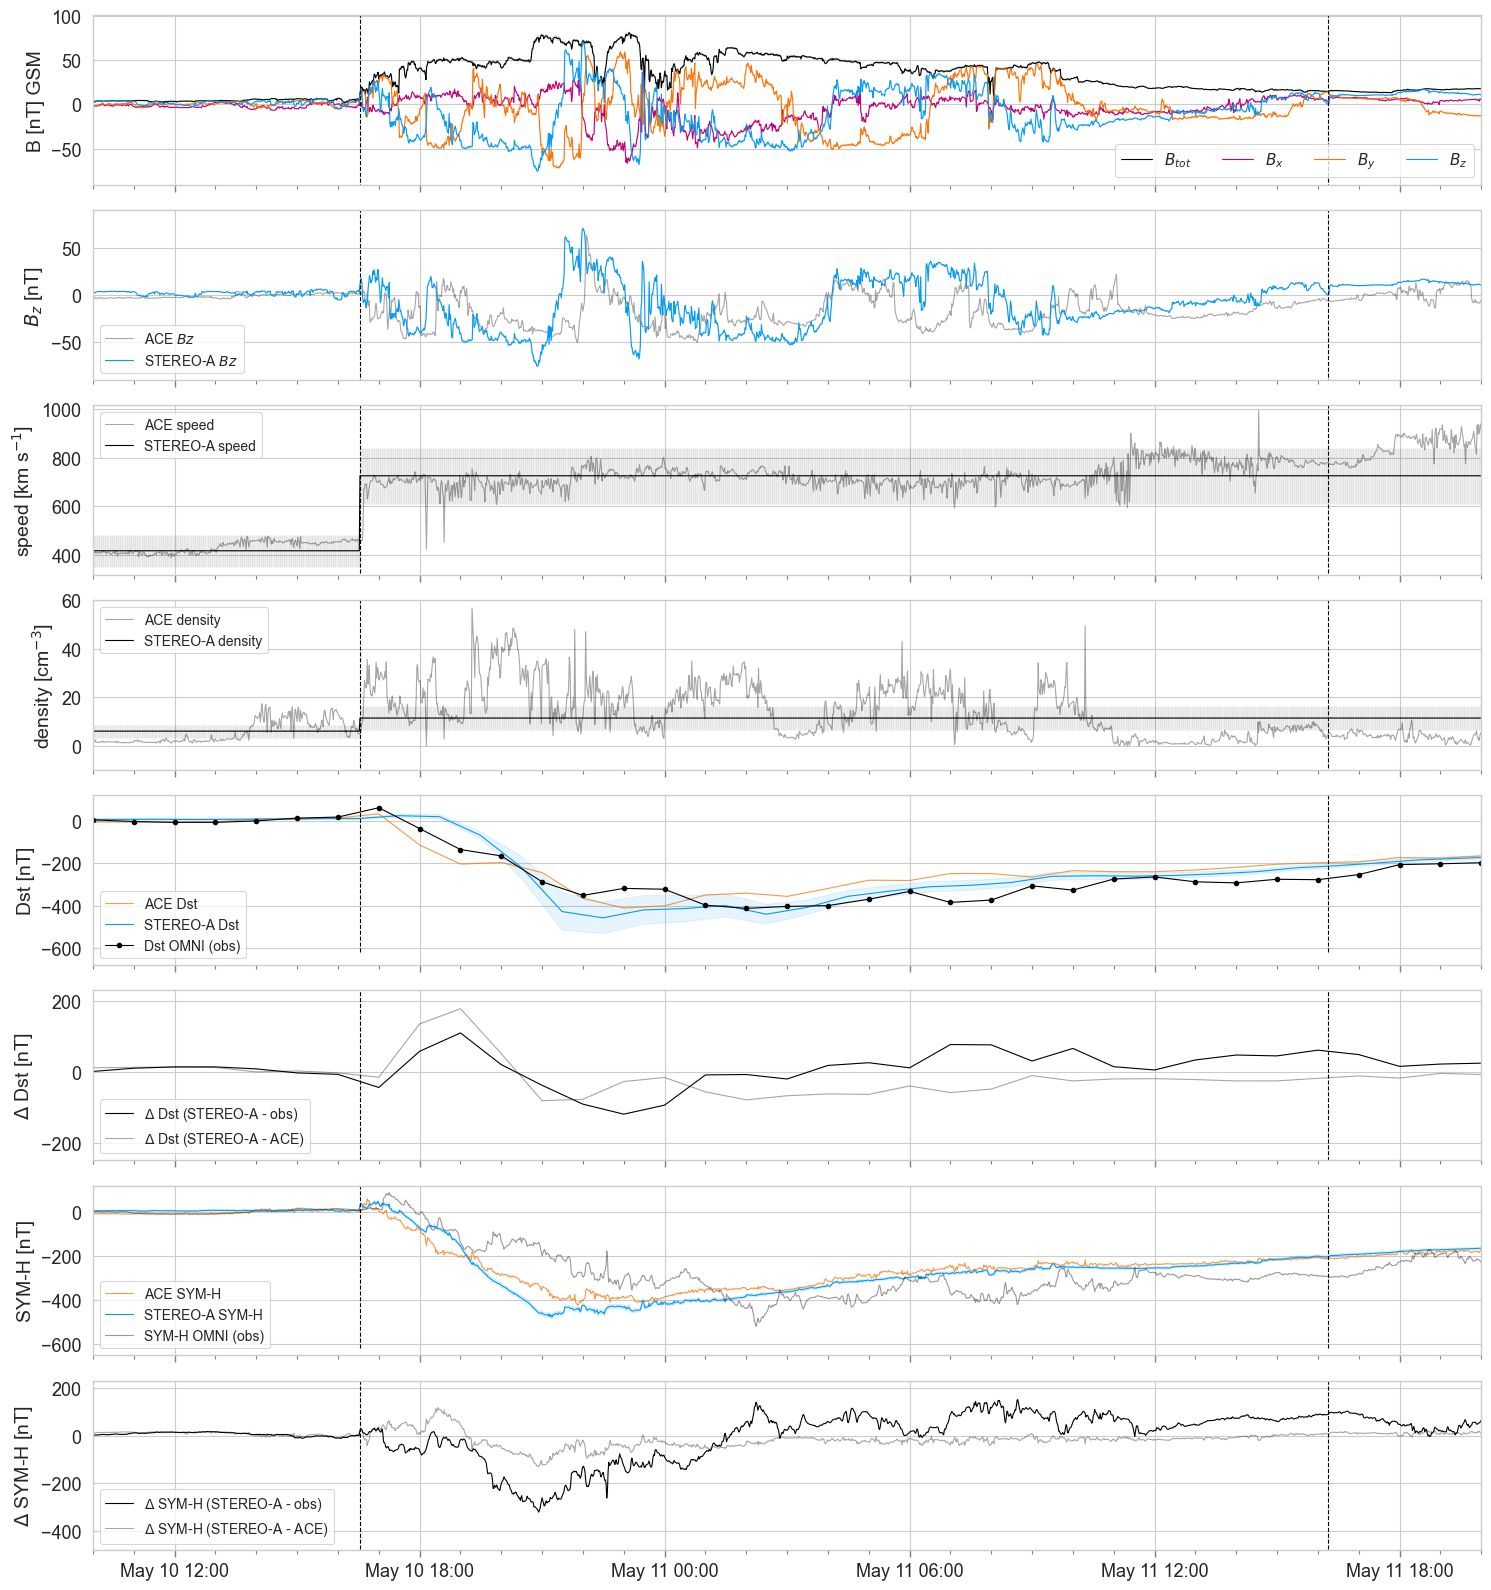

In [13]:
lw = 0.8
fntsize=14
days_dist = 1/4
a=0.05

label='ACE'

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, sharex=True, figsize=(15,16), dpi=100)

ax1.plot(mdates.num2date(sta_scaled_shifted['time']), sta_scaled_shifted['btot'], color=c0, label=r'$B_{tot}$', lw=lw)
ax1.plot(sta_scaled_shifted['time'], sta_scaled_shifted['bx'], color=c1, label=r'$B_{x}$', lw=lw)
ax1.plot(sta_scaled_shifted['time'], sta_scaled_shifted['by'], color=c2, label=r'$B_{y}$', lw=lw)
ax1.plot(sta_scaled_shifted['time'], sta_scaled_shifted['bz'], color=c3, label=r'$B_{z}$', lw=lw)
ax1.plot([sta_event_start,sta_event_start], [(-np.max(sta_scaled['btot'])-20),(np.max(sta_scaled['btot'])+20)], 'k--', lw=lw)
ax1.plot([sta_event_end,sta_event_end], [(-np.max(sta_scaled['btot'])-20),(np.max(sta_scaled['btot'])+20)], 'k--', lw=lw)
ax1.errorbar(sta_scaled_shifted['time'], sta_scaled_shifted['btot'], yerr=sta_scaled_shifted['btot_err'], color=c0, alpha=a)
ax1.errorbar(sta_scaled_shifted['time'], sta_scaled_shifted['bx'], yerr=sta_scaled_shifted['bx_err'], color=c1, alpha=a)
ax1.errorbar(sta_scaled_shifted['time'], sta_scaled_shifted['by'], yerr=sta_scaled_shifted['by_err'], color=c2, alpha=a)
ax1.errorbar(sta_scaled_shifted['time'], sta_scaled_shifted['bz'], yerr=sta_scaled_shifted['bz_err'], color=c3, alpha=a)
ax1.set_xlim(datetime(2024,5,10,0,0)+timedelta(minutes=time_shift_minutes), datetime(2024,5,13,0,0))
ax1.tick_params(which='both', bottom=True, color='gray')
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax1.set_ylabel('B [nT] GSM', fontsize=fntsize)
ax1.set_ylim(-np.max(sta_scaled['btot'])-10,np.max(sta_scaled['btot'])+20)
ax1.legend(ncol=4, fontsize=fntsize-3,loc='lower right')
ax1.tick_params(axis='y', labelsize=13)


ax2.plot(l1_0['time'], l1_0['bz'], color=c0, alpha=a+.3, label=str(label)+' $Bz$', lw=lw)
ax2.plot(sta_scaled_shifted['time'], sta_scaled_shifted['bz'], color=c3, label=r'STEREO-A $Bz$', lw=lw)
ax2.errorbar(sta_scaled_shifted['time'], sta_scaled_shifted['bz'], yerr=sta_scaled_shifted['bz_err'], color=c3, alpha=a)
ax2.set_ylabel(r'$B_z$ [nT]', fontsize=fntsize)
ax2.plot([sta_event_start,sta_event_start], [-100,100], 'k--', lw=lw)
ax2.plot([sta_event_end,sta_event_end], [-100,100], 'k--', lw=lw)
ax2.tick_params(which='both', bottom=True, color='gray')
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax2.set_ylim(-90,90)
ax2.tick_params(axis='y', labelsize=13)
ax2.legend(loc='lower left',fontsize=fntsize-4)

ax3.plot(l1_0['time'], l1_0['speed'], label=label+' speed', color=c0, alpha=a+.3, lw=lw)
ax3.plot(sta_scaled_shifted['time'], sta_scaled_shifted['speed'], label='STEREO-A speed', color=c0, lw=lw)
ax3.errorbar(sta_scaled_shifted['time'], sta_scaled_shifted['speed'], yerr=0.16*sta_scaled_shifted['speed'], color=c0, lw=lw, alpha=a)
ax3.plot([sta_event_start,sta_event_start], [(-np.min(sta_scaled_shifted['speed'])-1000),(np.max(sta_scaled_shifted['speed'])+1000)], 'k--', lw=lw)
ax3.plot([sta_event_end,sta_event_end], [(-np.min(sta_scaled_shifted['speed'])-1000),(np.max(sta_scaled_shifted['speed'])+1000)], 'k--', lw=lw)
ax3.set_ylabel(r'speed [km s$^{-1}$]', fontsize=fntsize)
ax3.set_ylim(np.min(sta_0['speed'])-100,np.max(l1_0['speed'])+10)
ax3.tick_params(which='both', bottom=True, color='gray')
ax3.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax3.legend(loc='upper left',fontsize=fntsize-4)
ax3.tick_params(axis='y', labelsize=13)

ax4.plot(l1_0['time'], l1_0['density'], label=label+' density', color=c0, alpha=a+.3, lw=lw)
ax4.plot(sta_scaled_shifted['time'], sta_scaled_shifted['density'], label='STEREO-A density', color=c0, lw=lw)
ax4.errorbar(sta_scaled_shifted['time'], sta_scaled_shifted['density'], yerr=0.43*sta_scaled_shifted['density'], color=c0, lw=lw, alpha=a)
ax4.set_ylabel(r'density [cm$^{-3}$]', fontsize=fntsize)
ax4.plot([sta_event_start,sta_event_start], [(np.min(sta_scaled_shifted['density'])-100),(np.max(sta_scaled_shifted['density'])+100)], 'k--', lw=lw)
ax4.plot([sta_event_end,sta_event_end], [(np.min(sta_scaled_shifted['density'])-100),(np.max(sta_scaled_shifted['density'])+100)], 'k--', lw=lw)
ax4.set_ylim(np.min(l1_0['density'])-10,60.)#np.max(l1_0['density'])+10)
ax4.tick_params(which='both', bottom=True, color='gray')
ax4.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax4.legend(loc='upper left',fontsize=fntsize-4)
ax4.tick_params(axis='y', labelsize=13)

ax5.plot(l1_0_hour['time'], l1_0_hour['dst'], color=c2, label=str(label)+' Dst',alpha=0.7, lw=lw)
ax5.errorbar(l1_0_hour['time'], l1_0_hour['dst'], yerr=np.std(l1_dst, axis=0), color=c2, alpha=a, lw=lw)
ax5.plot(sta_scaled_shifted_hour['time'], sta_scaled_shifted_hour['dst'], color=c3, label='STEREO-A Dst', lw=lw)
ax5.plot(olr['time'], olr['dst'], color='black', marker='o', ms=3, linestyle='-', label='Dst OMNI (obs)', lw=lw)
ax5.plot([sta_event_start,sta_event_start], [(np.min(ohr['symh'])-100),(np.max(ohr['symh'])+100)], 'k--', lw=lw)
ax5.plot([sta_event_end,sta_event_end], [(np.min(ohr['symh'])-100),(np.max(ohr['symh'])+100)], 'k--', lw=lw)
ax5.fill_between(sta_scaled_shifted_hour['time'], sta_scaled_shifted_hour['dst_err_max'], sta_scaled_shifted_hour['dst_err_min'], color=c3, alpha=0.1)
ax5.set_ylabel('Dst [nT]', fontsize=fntsize)
ax5.tick_params(which='both', bottom=True, color='gray')
ax5.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax5.set_ylim(-680,120)
ax5.tick_params(axis='y', labelsize=13)
ax5.legend(fontsize=fntsize-4)

ax6.plot(sta_shifted_interp_omni_hour['time'], delta_symh_obs_hour, color=c0, label='$\Delta$ Dst (STEREO-A - obs)', lw=lw)
ax6.plot(sta_shifted_interp_hour['time'], delta_symh_l1_hour, color=c0, alpha=a+.3, label='$\Delta$ Dst (STEREO-A - '+str(label)+')', lw=lw)
ax6.set_ylabel(r'$\Delta$ Dst [nT]', fontsize=fntsize)
ax6.plot([sta_event_start,sta_event_start], [-500,400], 'k--', lw=lw)
ax6.plot([sta_event_end,sta_event_end], [-500,400], 'k--', lw=lw)
ax6.legend(loc='lower left',fontsize=fntsize-4)
ax6.tick_params(which='both', bottom=True, color='gray')
ax6.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax6.set_ylim(-250,230)
ax6.tick_params(axis='x', labelsize=13)
ax6.tick_params(axis='y', labelsize=13)
ax6.set_xlim(datetime(2024,5,10,10,0), datetime(2024,5,11,20,0))
ax6.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M') )
ax6.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
ax6.tick_params(which='both', bottom=True, color='gray')
ax6.xaxis.set_minor_locator(mdates.HourLocator(interval=1))

ax7.plot(l1_0['time'], l1_0['symh'], color=c2, label=str(label)+' SYM-H',alpha=0.7, lw=lw)
ax7.errorbar(l1_0['time'], l1_0['symh'], yerr=np.std(l1_symh, axis=0), color=c2, alpha=a, lw=lw)
ax7.plot(sta_scaled_shifted['time'], sta_scaled_shifted['symh'], color=c3, label='STEREO-A SYM-H', lw=lw)
ax7.plot(ohr['time'],ohr['symh'], color='xkcd:black', label='SYM-H OMNI (obs)', alpha=0.4, lw=lw)
ax7.plot([sta_event_start,sta_event_start], [(np.min(ohr['symh'])-100),(np.max(ohr['symh'])+100)], 'k--', lw=lw)
ax7.plot([sta_event_end,sta_event_end], [(np.min(ohr['symh'])-100),(np.max(ohr['symh'])+100)], 'k--', lw=lw)
ax7.fill_between(sta_scaled_shifted['time'], sta_scaled_shifted['symh_err_max'], sta_scaled_shifted['symh_err_min'], color=c3, alpha=0.1)
ax7.tick_params(which='both', bottom=True, color='gray')
ax7.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax7.set_ylabel('SYM-H [nT]', fontsize=fntsize)
ax7.set_ylim(-650,120)
ax7.tick_params(axis='y', labelsize=13)
ax7.legend(fontsize=fntsize-4)

ax8.plot(sta_scaled['time'], delta_symh_obs, color=c0, label='$\Delta$ SYM-H (STEREO-A - obs)', lw=lw)
ax8.plot(sta_shifted_interp['time'], delta_symh_l1, color=c0, alpha=a+.3, label='$\Delta$ SYM-H (STEREO-A - '+str(label)+')', lw=lw)
ax8.set_ylabel(r'$\Delta$ SYM-H [nT]', fontsize=fntsize)
ax8.plot([sta_event_start,sta_event_start], [-500,400], 'k--', lw=lw)
ax8.plot([sta_event_end,sta_event_end], [-500,400], 'k--', lw=lw)
ax8.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M') )
ax8.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
ax8.tick_params(which='both', bottom=True, color='gray')
ax8.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax8.legend(loc='lower left',fontsize=fntsize-4)
ax8.set_ylim(-480,230)
ax8.tick_params(axis='x', labelsize=13)
ax8.tick_params(axis='y', labelsize=13)
ax8.set_xlim(datetime(2024,5,10,10,0), datetime(2024,5,11,20,0))

fig.tight_layout()

#plt.savefig('figures/STEREO-A_'+str(label)+'_INGRID.pdf')

## 5. calculate plasma beta, total pressure, shock/discontinuity normals using ACE science data

In [14]:
#calculate plasma beta, total pressure, shock normals 

[ace_input, ace_header] = pickle.load(open(data_path+'ace_gsm.p', 'rb'))

ace_0 = SatData({'time': date2num(ace_input.time),
               'btot': ace_input.bt, 'bx': ace_input.bx, 
               'by': ace_input.by, 'bz': ace_input.bz,
               'speed': ace_input.vt, 'speedx': ace_input.vx, 'speedy': ace_input.vy, 'speedz': ace_input.vz,
               'density': ace_input.np, 
               'temp': ace_input.tp}, source='ACE')

ace_0.interp_nans()

beta = (ace_0['density']*1e-6*1.38e-23*ace_0['temp'])/(ace_0['btot']*1e-9)**2/(2*1.3e-6)

p_tot = ((ace_0['density']*1e-6*1.38e-23*ace_0['temp']) + (ace_0['btot']*1e-9)**2/(2*1.3e-6))*1e9

el_field = (ace_0['speed']*1e3 * ace_0['bz']*1e-9)*1e3

shock = 1

if shock == 1:
    shock_arr_time = datetime(2024,5,10,16,36)
    shock_arr_time_sta = datetime(2024,5,10,14,3)
    ace_cov = copy.deepcopy(ace_0)
    ace_cov = ace_cov.cut(shock_arr_time, shock_arr_time+timedelta(minutes=152))

    
if shock == 2:
    shock_arr_time = datetime(2024,5,10,21,38)
    shock_arr_time_sta = datetime(2024,5,10,18,14)
    ace_cov = copy.deepcopy(ace_0)
    ace_cov = ace_cov.cut(shock_arr_time, shock_arr_time+timedelta(minutes=25))
    
if shock == 3:
    shock_arr_time = datetime(2024,5,11,0,2)
    shock_arr_time_sta = datetime(2024,5,11,21,41)
    ace_cov = copy.deepcopy(ace_0)
    ace_cov = ace_cov.cut(shock_arr_time, shock_arr_time+timedelta(minutes=136))
    
    
B_sheath = np.array([ace_cov['bx'], ace_cov['by'], ace_cov['bz']])
B_cov = np.cov(B_sheath)
eigvalue_Bcov, eigvec_Bcov = np.linalg.eig(B_cov)
n_mva = eigvec_Bcov[np.where(eigvalue_Bcov == eigvalue_Bcov.min())[0][0]]

ace_up_0 = copy.deepcopy(ace_0)
ace_down_0 = copy.deepcopy(ace_0)

ace_up = ace_up_0.cut(shock_arr_time-timedelta(minutes=10), shock_arr_time-timedelta(minutes=0))
ace_down = ace_down_0.cut(shock_arr_time+timedelta(minutes=1), shock_arr_time+timedelta(minutes=10))

#print(ace_up)
#print(ace_down)

sta_up_0 = copy.deepcopy(sta_0)
sta_down_0 = copy.deepcopy(sta_0)

sta_up = sta_up_0.cut(shock_arr_time_sta-timedelta(minutes=9), shock_arr_time_sta-timedelta(minutes=0))
sta_down = sta_down_0.cut(shock_arr_time_sta+timedelta(minutes=2), shock_arr_time_sta+timedelta(minutes=12))

B_up = np.array([np.mean(ace_up['bx']), np.mean(ace_up['by']), np.mean(ace_up['bz'])]) 
B_down = np.array([np.mean(ace_down['bx']), np.mean(ace_down['by']), np.mean(ace_down['bz'])])
Btot_up = np.mean(ace_up['btot'])
v_up = np.array([np.mean(ace_up['speedx']), np.mean(ace_up['speedy']), np.mean(ace_up['speedz'])]) 
v_down = np.array([np.mean(ace_down['speedx']), np.mean(ace_down['speedy']), np.mean(ace_down['speedz'])]) 
t_up = np.mean(ace_up['temp'])
n_up = np.mean(ace_up['density'])
n_down = np.mean(ace_down['density'])

B_up_sta = np.array([np.mean(sta_up['bx']), np.mean(sta_up['by']), np.mean(sta_up['bz'])]) 
B_down_sta = np.array([np.mean(sta_down['bx']), np.mean(sta_down['by']), np.mean(sta_down['bz'])])

down_minus_up = B_down - B_up 
down_cross_up = np.cross(B_down,B_up)

down_minus_up_sta = B_down_sta - B_up_sta 
down_cross_up_sta = np.cross(B_down_sta,B_up_sta)

down_minus_up_v = v_down - v_up
b_cross_v = np.cross(down_minus_up, down_minus_up_v)
b_up_cross_delta_v = np.cross(B_up, down_minus_up_v)
b_down_cross_delta_v = np.cross(B_down, down_minus_up_v)


n_mc = np.cross(down_cross_up,down_minus_up)/np.linalg.norm(np.cross(down_cross_up,down_minus_up))
n_md1 = np.cross(b_up_cross_delta_v,down_minus_up)/np.linalg.norm(np.cross(b_up_cross_delta_v,down_minus_up))
n_md2 = np.cross(b_down_cross_delta_v,down_minus_up)/np.linalg.norm(np.cross(b_down_cross_delta_v,down_minus_up))
n_md3 = np.cross(b_cross_v,down_minus_up)/np.linalg.norm(np.cross(b_cross_v,down_minus_up))
n_vc = down_minus_up_v/np.linalg.norm(down_minus_up_v)

n_mc_sta = np.cross(down_cross_up_sta,down_minus_up_sta)/np.linalg.norm(np.cross(down_cross_up_sta,down_minus_up_sta))

theta_Bn_mc = 180/np.pi * np.arccos(np.abs(np.dot(B_up, n_mc))/(np.linalg.norm(B_up)*np.linalg.norm(n_mc)))
theta_Bn_md1 = 180/np.pi * np.arccos(np.abs(np.dot(B_up, n_md1))/(np.linalg.norm(B_up)*np.linalg.norm(n_md1)))
theta_Bn_md2 = 180/np.pi * np.arccos(np.abs(np.dot(B_up, n_md2))/(np.linalg.norm(B_up)*np.linalg.norm(n_md2)))
theta_Bn_md3 = 180/np.pi * np.arccos(np.abs(np.dot(B_up, n_md3))/(np.linalg.norm(B_up)*np.linalg.norm(n_md3)))
theta_Bn_mva = 180/np.pi * np.arccos(np.abs(np.dot(B_up, n_mva))/(np.linalg.norm(B_up)*np.linalg.norm(n_mva)))
theta_Bn_vc = 180/np.pi * np.arccos(np.abs(np.dot(B_up, n_vc))/(np.linalg.norm(B_up)*np.linalg.norm(n_vc)))

theta_Bn_mc_sta = 180/np.pi * np.arccos(np.abs(np.dot(B_up_sta, n_mc_sta))/(np.linalg.norm(B_up_sta)*np.linalg.norm(n_mc_sta)))

if shock == 4:
    n_all = np.array([n_mc, n_md1, n_md2, n_md3])#, n_mva])
    theta_Bn_all = np.array([theta_Bn_mc, theta_Bn_md1, theta_Bn_md2, theta_Bn_md3])#, theta_Bn_mva])
                             
else:
    n_all = np.array([n_mc, n_md1, n_md2, n_md3, n_vc])#, n_mva])
    theta_Bn_all = np.array([theta_Bn_mc, theta_Bn_md1, theta_Bn_md2, theta_Bn_md3, theta_Bn_vc])#, theta_Bn_mva])
                             

#print('  ')
#print('n_mc, n_md1, n_md2, n_md3, n_vc: ', n_mc, n_md1, n_md2, n_md3, n_vc)
#print('n_mva: ', n_mva)
#print('n_mc STEREO-A: ', n_mc_sta)
#print('  ')
#print('theta_Bn_mc, md1, md2, md3, vc: ', theta_Bn_mc, theta_Bn_md1, theta_Bn_md2, theta_Bn_md3, theta_Bn_vc)
#print('theta_Bn_mc STEREO-A: ', theta_Bn_mc_sta)
#print('  ')
print('shock normal: ', np.round(np.mean(theta_Bn_all),0), '+/-', np.round(np.std(theta_Bn_all),0), 'deg') 

shock normal:  46.0 +/- 6.0 deg


In [15]:
#calculate shock speed, alfvenic, sound and magnetosonic speed as well as Mach numbers

v_shock_list = []
v_rel_list = []
M_a_list = []
M_ms_list = []

for i in n_all:
    
    v_shock_first_term = (n_down*v_down - n_up*v_up)/(n_down-n_up)
    v_shock = np.abs(np.dot(v_shock_first_term,i))
    v_rel = np.abs(np.dot(v_up,i)-v_shock)
    v_a_up = np.round(Btot_up*1e-9/(np.sqrt(1.3e-6*n_up*1e6*1.67e-27))*1e-3,2)
    c_s_up = np.round(np.sqrt(5/3*1.38e-23*t_up/1.67e-27)*1e-3,2)
    v_ms_up = np.round(np.sqrt(v_a_up**2 + c_s_up**2),2)
    
    M_a = v_rel/v_a_up
    M_ms = v_rel/v_ms_up
    
    v_shock_list.append(v_shock)
    v_rel_list.append(v_rel)
    M_a_list.append(M_a)
    M_ms_list.append(M_ms)

print('shock speed (km/s): ', np.round(np.mean(v_shock_list),0), np.round(np.std(v_shock_list),0))
print('rel. shock speed (km/s): ', np.round(np.mean(v_rel_list),0), np.round(np.std(v_rel_list),0))
print('upstream alfven speed (km/s): ', v_a_up)
print('upstream sound speed (km/s): ', c_s_up)
print('upstream magnetosonic speed (km/s): ', v_ms_up)
print('alfvenic Mach number: ', np.round(np.mean(M_a_list),2), np.round(np.std(M_a_list),3))
print('fast magnetosonic Mach number: ', np.round(np.mean(M_ms_list),1), np.round(np.std(M_ms_list),3))

shock speed (km/s):  684.0 41.0
rel. shock speed (km/s):  328.0 11.0
upstream alfven speed (km/s):  26.54
upstream sound speed (km/s):  19.88
upstream magnetosonic speed (km/s):  33.16
alfvenic Mach number:  12.37 0.411
fast magnetosonic Mach number:  9.9 0.329
